# Scanning Parameters in T Cell Ternary Body Formation
## Analyzing antibody dissociation from covalently bonded SNAP
This is a script for analyzing the importance of the antibody dissociation rate from a CAR T Cell or a SNAP T Cell. Where as the setup script assumed no dissociation between T Cells and the antibody, we will be scanning the parameter space for optimum dissociation rates. 

### Importing the important packages to simulate the model.

In [8]:
import matplotlib.gridspec as gridspec
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import math

### Input of key variables
Here is where the user should define the variables they are interested in parameter scanning and simulating. We would like to notes that these are just some of the parameters that a user can modify and more variables are included below. The variables included here are ones relevant to different antibody-target pairs while those included later are more related to the experimental setup. 

In [9]:
#Parameters for the parameter scan
Dissociation_Rate_upper_bound = 10**-3 #(units = M) Dissociation constant of antibody in Molar 
Dissociation_Rate_lower_bound = 10**-9 #(units = M) Dissociation constant of antibody in Molar

#Regular Parameters from before
number_of_receptors_per_Tcell = 100000  #(units = molecules per cell) Receptors per T cell
number_of_receptors_per_tumor = 100000  #(units = molecules per cell) Receptors per Tumor cell
alpha = 10                              #Cooperativity rate 
                                        #####   Cooperativity   #####
                                        # (0 to 1)  is negative cooperativity
                                        # (1)       is no cooperativitiy
                                        # (1 to inifinity) is positive cooperativity

### Calculation of key variables and parameterization of the system of ODEs 
Please note that since we are interested in equilibrium concentrations, the rates of reactions are not incredibly important; rather, the ratio of forward rates to backward rates (association and dissociation equilibirum constants) are what dictate equilibirum concentrations.

In [10]:
#Calculating the number of steps to effectively show the parameter scan
log_lower_bound = np.log10(Dissociation_Rate_lower_bound) 
log_upper_bound = np.log10(Dissociation_Rate_upper_bound) 
step_size = int(abs(log_lower_bound-log_upper_bound) + 1)
# step_size = 7                           #The number of steps in the parameter scan (logarithmic)

#Variables given for the experimental setup
Avogadro_number = 6.022140857 * (10**23)                 #Avogadro's Number of Molecules per mole
reaction_volume = 150                                    #150 uL reaction volume
number_of_Snap_Tcells = 150000                           #150,000 T Cells in reaction
number_of_tumor_cells = 400000                           #400,000 Tumor Cells in reaction      

#Calculating the initial molecular concentrations
Concentration_of_T_Cells = number_of_Snap_Tcells * number_of_receptors_per_Tcell * \
                               (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume)
Concentration_of_Tumor_Cells = number_of_tumor_cells * number_of_receptors_per_tumor * \
                               (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume)
Concentration_of_Antibody = 1 #Necessary to initialize the simulation, actual value is a range


#Saving the variables for simulation
Initial = [Concentration_of_T_Cells,Concentration_of_Antibody,Concentration_of_Tumor_Cells,0,0,0]
parameter_range = np.logspace(log_lower_bound,log_upper_bound,num=step_size, endpoint=True, base=10.0)
time = np.linspace(0,100000000,10000)

### The function of ODEs for simulation (copied from the setup file)
Here is where the rates, concentrations, and reactions are defined for simulation. Due to the nature of this function, only initial concentrations (C) and time (t) can be sent to the function. A global variable (k) with all the calculated rate constants are sent separately. The function returns the rates of change for each concentration.

In [11]:
def rxn(C,t):
    #Loading the global variable reaction rates
    kf1 = k[0]                                             
    kr1 = k[1]                                             
    kf2 = k[2]                                             
    kr2 = k[3]                                             
    kf3 = k[4]                                             
    kr3 = k[5]                                             
    kf4 = k[6]                                             
    kr4 = k[7]        
    
    #Loading the initial concentrations
    C_snap = C[0]                   #initial concentration of free T Cell receptor
    C_anti = C[1]                   #initial concentration of free antibody
    C_tumo = C[2]                   #initial concentration of free Tumor cell receptor
    C_snap_anti = C[3]              #initial concentration of bound T Cell - Antibody
    C_anti_tumo = C[4]              #initial concentration of bound Tumor Cell - Antibody
    C_snap_anti_tumo = C[5]         #initial concentration of Ternary Body
    
    #Separation of key equation terms for simplicity
    term1 = kf1 * C_snap * C_anti           #binding of Tcell to antibody                              
    term2 = kr1 * C_snap_anti               #dissociation of Tcell - antibody
    term3 = kf2 * C_anti * C_tumo           #binding of TumorCell to antibody
    term4 = kr2 * C_anti_tumo               #dissociation of TumorCell - antibody
    term5 = kf3 * C_snap_anti * C_tumo      #binding of Tcell-antibody to Tumor Cell
    term6 = kr3 * C_snap_anti_tumo          #dissociation of Ternary Body
    term7 = kf4 * C_anti_tumo * C_snap      #binding of TumorCell-antibody to T Cell
    term8 = kr4 * C_snap_anti_tumo          #dissociation of Ternary Body
    
    #ODEs that model the dynamic change in concentration of each chemical species
    d_C_snap_dt = - term1 + term2 - term7 + term8           #change in free T Cell receptor
    d_C_anti_dt = - term1 + term2 - term3 + term4           #change in free antibody
    d_C_tumo_dt = - term3 + term4 - term5 + term6           #change in free Tumor cell receptor
    d_C_snap_anti_dt = + term1 - term2 - term5 + term6      #change in bound T Cell - Antibody
    d_C_anti_tumo_dt = + term3 - term4 - term7 + term8      #change in bound Tumor Cell - Antibody
    d_C_snap_anti_tumo_dt = + term5 - term6 + term7 - term8 #change in Ternary Body
    
    return([d_C_snap_dt,d_C_anti_dt,d_C_tumo_dt,d_C_snap_anti_dt,d_C_anti_tumo_dt,d_C_snap_anti_tumo_dt])

### Simulation and Plotting Equilibrium Concentrations over a Range of Antibody Release Rates

In this analysis, we simulate the same situation as above but varying the antibody unbinding rate. We will be scanning a logarithmic space from 10e-12 to 10e-6. Please note that the analysis above took place at Kd of 15 * 10e-9 (or 15 nM).

In [12]:
#creating an empty list to store simulation data
data = []

#the for look to go over the range of the parameter scan
for dissociation_rate in parameter_range:
    Antibody_dissociation = dissociation_rate
    #Calculating the Kinetic Parameters - since we only have equilibrium data, we are interested in ratios, not numbers
    k_binding_snap_to_antibody = 10**-5                      #
    k_release_snap_to_antibody = Antibody_dissociation  #Scanning the dissociation rate
    k_binding_antibody_to_tumor = 10**-5 
    k_release_antibody_to_tumor = k_binding_antibody_to_tumor * Antibody_dissociation * 10**-9
    k_cooperativity_binding_snap = k_binding_snap_to_antibody * alpha
    k_cooperativity_releasing_snap = k_release_snap_to_antibody * alpha
    k_cooperativity_binding_tumor = k_binding_antibody_to_tumor * alpha
    k_cooperativity_releasing_tumor = k_release_antibody_to_tumor * alpha

    k = [k_binding_snap_to_antibody,k_release_snap_to_antibody,k_binding_antibody_to_tumor,\
         k_release_antibody_to_tumor,k_cooperativity_binding_snap,k_cooperativity_releasing_snap,\
         k_cooperativity_binding_tumor,k_cooperativity_releasing_tumor]
    
    N = 100
    antibody_range = np.logspace(-3,1,N)
    ternary_body = []
    
    #the for loop to go over the range of the antibody concentrations
    for i in antibody_range:
        Initial[1] = i
        C = odeint(rxn,Initial,time)
        ternary_body.append(float((C[100,5])))
    data.append(ternary_body)

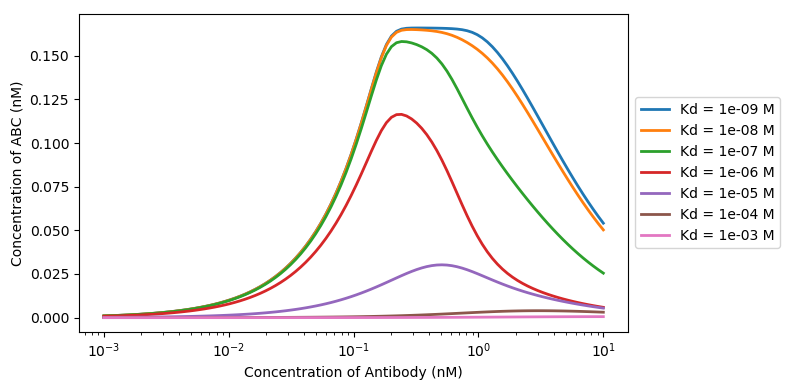

In [13]:
#Create the figure and set the layout
fig = plt.figure(figsize=(8, 4), dpi=100)
gs1 = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs1[0])
plt.xlabel('Concentration of Antibody (nM)')
plt.ylabel('Concentration of ABC (nM)')
plt.xscale("log")

#Create a legend for the figure
legend_list = []
for i in range(0,step_size):
    ax.plot(antibody_range,data[i],linewidth=2.0)
    legend_list.append('Kd = '+ '{:.0e}'.format(parameter_range[i]) + ' M')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(legend_list,loc='center left', bbox_to_anchor=(1, 0.5))

#Creating the plot, saving it, and showing it
gs1.tight_layout(fig)
gs1.tight_layout(fig, rect=[0, 0, 1, 1])
plt.savefig('Figures/Figure3_ParameterScan_AntibodyDissociation.png')
plt.show()